In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Modify the Data Preprocessing

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths for dataset and outputs
dataset_path = '/content/drive/My Drive/dataset/'  # Adjust this path as per your data location
output_path = '/content/drive/My Drive/'  # Adjust this path for saving models/pickles

# Constants
IMG_SIZE = 128  # Target image size for resizing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Prepare dataset
categories = [cat for cat in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cat))]
print("Categories:", categories)

data = []
labels = []

# Process each category folder
for category in categories:
    category_path = os.path.join(dataset_path, category)

    # Check Train and Validation subfolders
    for subfolder in ["Train", "Validation"]:
        subfolder_path = os.path.join(category_path, subfolder)

        if not os.path.exists(subfolder_path):
            print(f"Skipping missing folder: {subfolder_path}")
            continue

        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)

            # Skip non-image files
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Skipping non-image file: {img_path}")
                continue

            try:
                img_array = cv2.imread(img_path)  # Load image
                if img_array is None:
                    print(f"Failed to load {img_path}")
                    continue

                # Resize the image to the target size
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append(img_array)
                labels.append(category)  # Label as folder name
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
if len(data) > 0:
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels)

    # Encode labels
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    # Save category mapping for later use
    category_names = {i: cat for i, cat in enumerate(le.classes_)}
    with open("categories.pkl", "wb") as file:
        pickle.dump(category_names, file)
    print("Category mapping saved:", category_names)
else:
    print("No valid images found. Check dataset structure.")

Categories: ['Faysal', 'Tareq', 'Mohim', 'Tanzil']
Category mapping saved: {0: 'Faysal', 1: 'Mohim', 2: 'Tanzil', 3: 'Tareq'}


In [5]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

# Preprocess data for MobileNetV2
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Print dataset shapes
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (672, 128, 128, 3)
Validation data shape: (168, 128, 128, 3)
Training labels shape: (672, 4)
Validation labels shape: (168, 4)


In [6]:
# Load MobileNetV2 without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(categories), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Define callbacks
best_model_path = os.path.join(output_path, 'model1.h5')  # Save as model.h5
checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7417 - loss: 0.7033
Epoch 1: val_loss improved from inf to 0.04588, saving model to /content/drive/My Drive/model1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.7449 - loss: 0.6947 - val_accuracy: 0.9940 - val_loss: 0.0459
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9984 - loss: 0.0260
Epoch 2: val_loss improved from 0.04588 to 0.03714, saving model to /content/drive/My Drive/model1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.9983 - loss: 0.0260 - val_accuracy: 0.9940 - val_loss: 0.0371
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 1.0000 - loss: 0.0152
Epoch 3: val_loss did not improve from 0.03714
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 1.0000 - loss: 0.0152 - val_accuracy: 0.9940 - val_loss: 0.0373
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 4: val_loss improved from 0.03714 to 0.02124, saving model to /content/drive/My Drive/model1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 345ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9940 - val_loss: 0.0212
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 5: val_loss did not improve from 0.02124
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9881 - val_loss: 0.0425
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 6: val_loss improved from 0.02124 to 0.01998, saving model to /content/drive/My Drive/model1.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9940 - val_loss: 0.0200
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 7: val_loss did not improve from 0.01998
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9881 - val_loss: 0.0478
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 8: val_loss did not improve from 0.01998
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9881 - val_loss: 0.0533
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 9: val_loss did not improve from 0.01998
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9881 - val_loss: 0.0338
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.


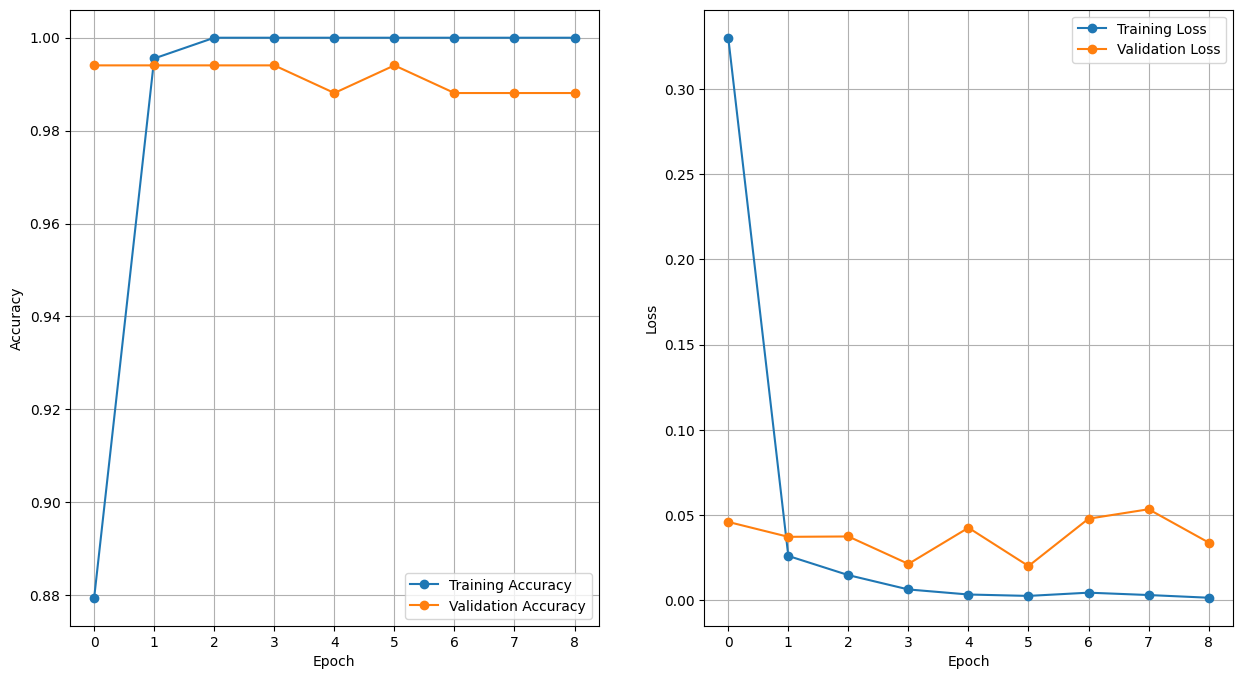

In [8]:
# Plot training history
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label='Training Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [9]:
# Save label encoder and category names
with open(os.path.join(output_path, 'label_encoder1.pkl'), 'wb') as f:
    pickle.dump(le, f)

with open(os.path.join(output_path, 'categories1.pkl'), 'wb') as f:
    pickle.dump(category_names, f)

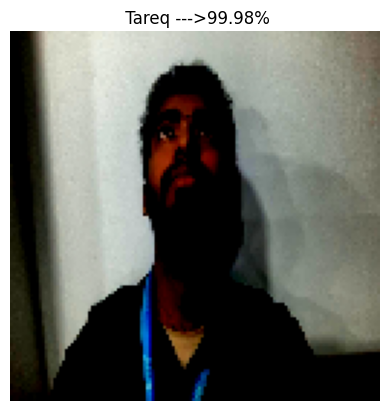

In [13]:
# Load the saved model
model = keras.models.load_model(best_model_path)

# Load the label encoder
with open(os.path.join(output_path, 'label_encoder1.pkl'), 'rb') as f:
    le = pickle.load(f)

# Function to preprocess and predict
def predict_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Resize and preprocess the image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img)
    img_array = np.expand_dims(img, axis=0)

    # Predict the label
    predictions = model.predict(img_array, verbose=0)
    confidence = np.max(predictions)
    label_index = np.argmax(predictions)
    label = le.classes_[label_index]

    # Display the result
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f" {label} --->{confidence*100:.2f}%")
    plt.show()

# Test the inference function
image_path = '/content/drive/My Drive/dataset/Tareq/Train/image_183.jpg'  # Update this to your image path
predict_image(image_path)